In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# New Section

In [3]:
from sklearn.metrics import accuracy_score,fbeta_score,classification_report
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
stop=stopwords.words("english")

from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
ss= SnowballStemmer("english")
ps=PorterStemmer()

In [5]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
link= 'https://drive.google.com/file/d//view?usp=1_e3YXeqT_QnI01ZDrg-ANFPIOGh5DnZS'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1_e3YXeqT_QnI01ZDrg-ANFPIOGh5DnZS


In [8]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('spam.csv')  
msg_df=pd.read_csv('spam.csv',sep='\t',names=["label","message"])
msg_df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4af83754a8>,
      dtype=object)

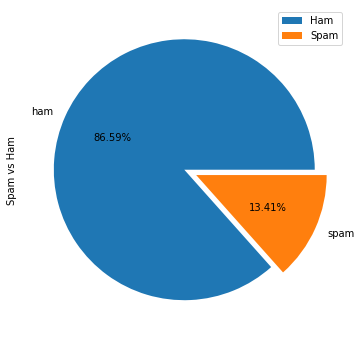

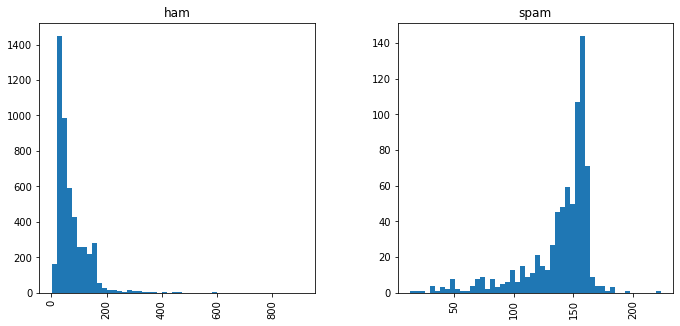

In [ ]:
msg_df.shape
msg_df['label'].value_counts().plot(kind='pie', explode=[0,0.1], figsize=(6,6),autopct='%1.2f%%')
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])

msg_df['length']=msg_df['message'].apply(len)
msg_df.hist(column='length',by='label',bins=50, figsize=(11,5))

In [ ]:
import string
def cleanText(message):
    message=re.sub('[^a-zA-Z]',' ', message)
    message= message.lower()
    message= message.split()
    words= [ss.stem(word) for word in message if word not in stop]
    return " ".join(words)
msg_df["message"] = msg_df["message"].apply(cleanText)
spam_messages= msg_df[msg_df["label"]=="spam"]["message"]
ham_messages= msg_df[msg_df["label"]=="ham"]["message"]


In [ ]:
spam_words = []
ham_words = []


def extractSpamWords(spamMessages):
    global spam_words
    words = [word for word in word_tokenize(spamMessages)]
    spam_words = spam_words + words

def extractHamWords(hamMessages):
    global ham_words
    words = [word for word in word_tokenize(hamMessages)]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
        ... 
5565    None
5568    None
5569    None
5570    None
5571    None
Name: message, Length: 4825, dtype: object

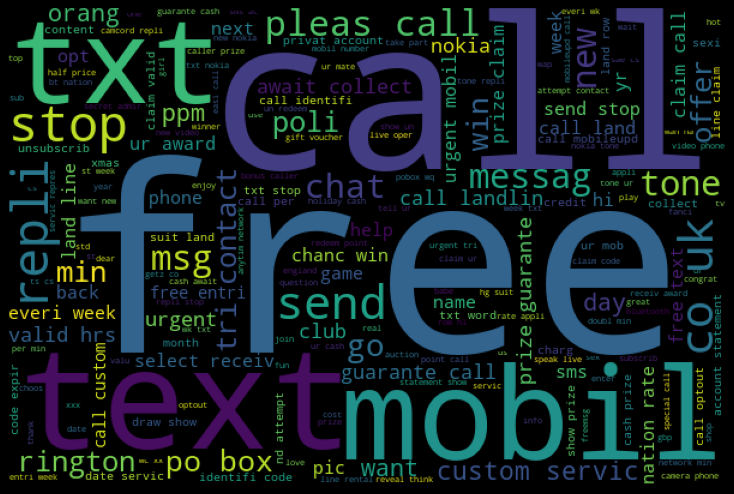

In [ ]:
spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

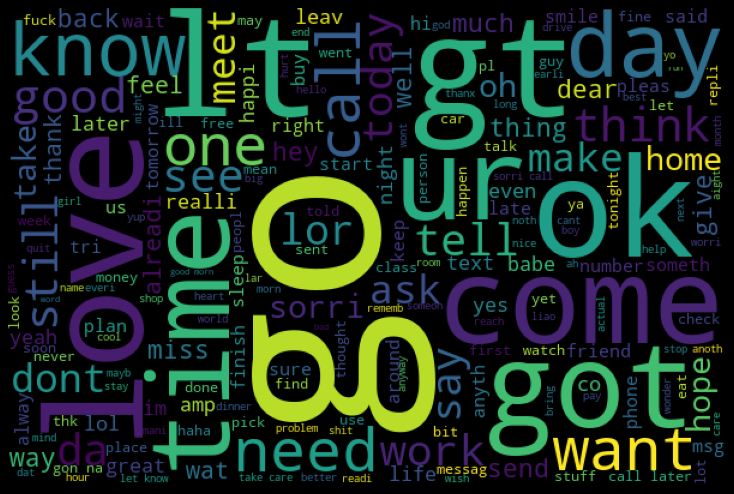

In [ ]:
ham_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

In [ ]:
def encoodeCategory(cat):
  if cat == "spam":
    return 1
  else:
    return 0

msg_df["label"]= msg_df["label"].apply(encoodeCategory)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
X= cv.fit_transform(msg_df["message"])
print(X.shape)
X= cv.fit_transform(msg_df["message"]).toarray() 

(5572, 6292)


In [ ]:
print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
df= pd.DataFrame(X,columns=cv.get_feature_names())
df['len']=msg_df['length']
y= msg_df['label']

In [ ]:
df.head()

,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,aberdeen,abi,abil,abiola,abj,abl,abnorm,abouta,abroad,absenc,absolut,abstract,abt,abta,aburo,abus,ac,academ,acc,accent,accentur,accept,access,accid,accident,accommod,accommodationvouch,accomod,accord,accordin,...,young,younger,youphon,your,yourinclus,yourjob,youuuuu,youwanna,yovill,yowif,yoyyooo,yr,yrs,ystrday,yt,ything,yummi,yummmm,yun,yunni,yuo,yuou,yup,yupz,zac,zaher,zealand,zebra,zed,zero,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada,len
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,155
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.20, random_state = 0)

# Training model using Naive bayes classifier

from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(X_train, y_train)

y_pred=spam_detect_model.predict(X_test)

In [ ]:
print(accuracy_score(y_test,y_pred,))
print(fbeta_score(y_test,y_pred, zero_division=1,beta =0.5))

1.0
1.0


In [ ]:
print (classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1115

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115



In [ ]:
saved_model=pickle.dumps(spam_detect_model)


In [ ]:
modelfrom_pickle = pickle.loads(saved_model) 
print(accuracy_score(y_test,y_pred))

In [ ]:
import joblib
joblib.dump(spam_detect_model,'pickle.pkl')
joblib.dump(X,'transform.pkl')

['transform.pkl']